In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from os import walk
from scipy.stats import spearmanr

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
all_tss_f = "../../data/00__index/0__all_tss/All.TSS.114bp.bed"

In [4]:
tss_cage_exp_f = "../../misc/other_files/TSS.CAGE_grouped_exp.tissue_sp.txt.gz"
enh_cage_exp_f = "../../misc/other_files/Enh.CAGE_grouped_exp.tissue_sp.txt.gz"

## 1. import data

In [5]:
all_tss = pd.read_table(all_tss_f, sep="\t", header=None)
all_tss.columns = ["chr", "start", "end", "name", "score", "strand"]
all_tss.head()

,chr,start,end,name,score,strand
0,chr1,10003350,10003465,"div_pc__p1@LZIC__chr1:10003372..10003465,-",0,-
1,chr1,10003452,10003567,protein_coding__p1@NMNAT1__chr1:10003486..1000...,0,+
2,chr1,100111588,100111703,protein_coding__p1@PALMD__chr1:100111580..1001...,0,+
3,chr1,100232148,100232263,protein_coding__p1@FRRS1__chr1:100232177..1002...,0,-
4,chr1,100315601,100315716,protein_coding__p1@AGL__chr1:100315613..100315...,0,+


In [6]:
tss_cage_exp = pd.read_table(tss_cage_exp_f, sep="\t")
tss_cage_exp.head()

,00Annotation,short_description,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
0,"chr10:100013403..100013414,-","p@chr10:100013403..100013414,-",0.54300,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.993829,0.666667
1,"chr10:100027943..100027958,-",p1@LOXL4,27.14998,0.89047,0.0,0.0,0.0,0.1056,0.0,0.101989,...,0.0,0.000000,0.0,0.0,1.603423,2.000139,0.629078,0.0,0.968756,0.666667
2,"chr10:100076685..100076699,+","p@chr10:100076685..100076699,+",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.984646,NaN
3,"chr10:100150910..100150935,-","p@chr10:100150910..100150935,-",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,0.548168,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.991970,NaN
4,"chr10:100150951..100150962,-","p@chr10:100150951..100150962,-",0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,...,0.0,1.096335,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.981522,NaN


In [7]:
tss_cage_exp[tss_cage_exp["00Annotation"] == "chr20:49575059..49575077,-"]

,00Annotation,short_description,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
102061,"chr20:49575059..49575077,-",p1@DPM1,79.277942,155.386952,78.052286,68.995652,47.83823,100.32032,40.422357,76.797589,...,101.771054,107.577911,114.335837,156.038327,37.680434,85.605942,118.626224,238.480723,0.833704,0.266991


In [8]:
tss_cage_exp["cage_id"] = tss_cage_exp["00Annotation"]
tss_cage_exp.drop(["00Annotation", "short_description"], axis=1, inplace=True)

In [9]:
enh_cage_exp = pd.read_table(enh_cage_exp_f, sep="\t")
enh_cage_exp.head()

,Id,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,...,Group_542,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3
0,chr1:839741-840250,0.0,0.216714,0.0,0.0,0.000000,0.102923,0.000000,0.0,0.0,...,0.0,0.00000,0.306431,0.206949,0.0,0.38338,0.087482,0.110784,0.981674,0.483654
1,chr1:840753-841210,0.0,0.216714,0.0,0.0,0.000000,0.000000,0.543603,0.0,0.0,...,0.0,0.13168,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.984912,0.483654
2,chr1:845485-845678,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.181201,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.990033,0.666667
3,chr1:855764-856157,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.990598,0.666667
4,chr1:856539-856757,0.0,0.000000,0.0,0.0,0.199924,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.00000,0.087482,0.000000,0.977400,0.479531


In [10]:
enh_cage_exp["cage_id"] = enh_cage_exp["Id"]
enh_cage_exp.drop(["Id"], axis=1, inplace=True)

In [11]:
all_cage_exp = tss_cage_exp.append(enh_cage_exp)
all_cage_exp.sample(5)

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id
109189,31.493977,32.279524,24.464149,27.398273,37.889571,13.728044,36.118124,11.422749,14.347868,13.763283,...,15.759821,13.432004,51.117932,21.646207,12.800888,26.6909,7.064407,0.867801,0.01987,"chr22:42475692..42475721,+"
12691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.998145,NaN,"chr11:19965862..19965871,-"
45104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.997868,NaN,"chr15:61055810..61055827,+"
109403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.991962,NaN,"chr22:44542638..44542650,+"
134111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.991234,NaN,"chr3:35680657..35680671,+"


In [12]:
all_cage_exp[all_cage_exp["cage_id"] == "chr20:49575059..49575077,-"]

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_543,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id
102061,79.277942,155.386952,78.052286,68.995652,47.83823,100.32032,40.422357,76.797589,89.674177,79.138877,...,107.577911,114.335837,156.038327,37.680434,85.605942,118.626224,238.480723,0.833704,0.266991,"chr20:49575059..49575077,-"


## 2. parse CAGE IDs

In [13]:
def get_cage_id(row):
    if "Enhancer" in row["name"]:
        return row["name"].split("__")[1]
    else:
        return row["name"].split("__")[2]

In [14]:
all_tss["cage_id"] = all_tss.apply(get_cage_id, axis=1)
all_tss.sample(5)

,chr,start,end,name,score,strand,cage_id
39449,chr19,14895637,14895752,Enhancer__chr19:14895618-14895793,0,+,chr19:14895618-14895793
52268,chr7,134287782,134287897,Enhancer__chr7:134287776-134287871,0,+,chr7:134287776-134287871
4216,chr11,18258314,18258429,protein_coding__p1@SAA4__chr11:18258342..18258...,0,-,"chr11:18258342..18258360,-"
24326,chr8,128231296,128231411,"intergenic__p3@ENST00000500112,p3@uc003ysa.1__...",0,-,"chr8:128231299..128231352,-"
16014,chr20,20248424,20248539,antisense__p3@ENST00000460400__chr20:20248447....,0,-,"chr20:20248447..20248465,-"


## 3. get av exp & t.s. across all samples

In [15]:
samples = [x for x in all_cage_exp.columns if "Group_" in x]
all_cage_exp["av_exp"] = all_cage_exp[samples].mean(axis=1)
all_cage_exp.sample(5)

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_544,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id,av_exp
7851,0.517281,0.000000,2.291115,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.985845,0.549611,chr10:74453097-74453245,0.107442
124417,0.000000,0.222617,0.000000,0.000000,0.00000,0.000000,0.187141,0.000000,0.000000,0.000000,...,0.32761,0.000000,0.000000,0.00000,0.089868,0.113942,0.979324,0.361016,"chr2:69135849..69135857,+",0.078340
138398,1.085999,2.560100,0.000000,2.799824,5.92686,2.745609,3.742811,0.815911,1.476986,1.966183,...,0.65522,2.348964,10.422248,3.60025,2.066972,2.962493,0.880731,0.114478,"chr4:106067811..106067854,+",4.317199
155084,0.000000,0.111309,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.983092,...,0.32761,0.000000,0.000000,0.00000,0.269605,0.000000,0.988861,0.666667,"chr5:68339691..68339711,-",0.157884
85020,0.000000,0.000000,0.000000,1.599899,0.00000,0.105600,0.000000,0.000000,0.210998,0.000000,...,0.00000,0.111855,0.000000,0.00000,0.000000,0.113942,0.967222,0.644345,"chr1:165609430..165609436,+",0.052442


## 4. merge

In [16]:
all_tss[all_tss["cage_id"] == "chr20:49575059..49575077,-"]

,chr,start,end,name,score,strand,cage_id


In [17]:
all_tss = all_tss.merge(all_cage_exp[["cage_id", "av_exp", "tissue_sp_all"]], on="cage_id")
all_tss.sample(5)

,chr,start,end,name,score,strand,cage_id,av_exp,tissue_sp_all
21075,chr10,26042859,26042974,Enhancer__chr10:26042706-26043028,0,+,chr10:26042706-26043028,0.006435,0.990887
11482,chr22,50765392,50765507,protein_coding__p1@FAM116B__chr22:50765355..50...,0,-,"chr22:50765355..50765456,-",4.828235,0.916594
30526,chr19,42037971,42038086,Enhancer__chr19:42037922-42038313,0,+,chr19:42037922-42038313,2.328728,0.961457
34475,chr20,57750219,57750334,Enhancer__chr20:57750104-57750489,0,+,chr20:57750104-57750489,0.068653,0.972865
24597,chr12,88700601,88700716,Enhancer__chr12:88700433-88700684,0,+,chr12:88700433-88700684,0.028676,0.987909


## 5. define promtype2

In [18]:
all_tss["PromType2"] = all_tss["name"].str.split("__", expand=True)[0]
all_tss.sample(5)

,chr,start,end,name,score,strand,cage_id,av_exp,tissue_sp_all,PromType2
22117,chr11,1040178,1040293,Enhancer__chr11:1039894-1040259,0,+,chr11:1039894-1040259,0.036636,0.996070,Enhancer
28309,chr16,88228347,88228462,Enhancer__chr16:88228373-88228428,0,+,chr16:88228373-88228428,0.015514,0.988800,Enhancer
17560,chrX,37544963,37545078,"protein_coding__p1@XK__chrX:37545026..37545064,+",0,+,"chrX:37545026..37545064,+",2.854488,0.976161,protein_coding
33312,chr2,70823882,70823997,Enhancer__chr2:70823866-70823963,0,+,chr2:70823866-70823963,0.028026,0.984807,Enhancer
28728,chr17,39654691,39654806,Enhancer__chr17:39654597-39654816,0,+,chr17:39654597-39654816,0.073470,0.996056,Enhancer


In [19]:
all_tss.PromType2.unique()

array(['div_pc', 'protein_coding', 'div_lnc', 'antisense', 'intergenic',
       'Enhancer'], dtype=object)

## 5. plot

In [20]:
all_tss["log_av_exp"] = np.log(all_tss["av_exp"]+1)

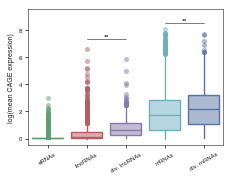

In [21]:
fig = plt.figure(figsize=(3.5, 2.5))
ax = sns.boxplot(data=all_tss, x="PromType2", y="log_av_exp", 
                 flierprops = dict(marker='o', markersize=5), order=TSS_CLASS_ORDER, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)


# calc p-vals b/w divergent and non
lincs = np.asarray(all_tss[all_tss["PromType2"] == "intergenic"]["log_av_exp"])
div_lncs = np.asarray(all_tss[all_tss["PromType2"] == "div_lnc"]["log_av_exp"])
pcs = np.asarray(all_tss[all_tss["PromType2"] == "protein_coding"]["log_av_exp"])
div_pcs = np.asarray(all_tss[all_tss["PromType2"] == "div_pc"]["log_av_exp"])

lincs = lincs[~np.isnan(lincs)]
div_lncs = div_lncs[~np.isnan(div_lncs)]
pcs = pcs[~np.isnan(pcs)]
div_pcs = div_pcs[~np.isnan(div_pcs)]

lnc_u, lnc_pval = stats.mannwhitneyu(lincs, div_lncs, alternative="two-sided", use_continuity=False)
pc_u, pc_pval = stats.mannwhitneyu(pcs, div_pcs, alternative="two-sided", use_continuity=False)
    
annotate_pval(ax, 1, 2, 7.3, 0, 7.15, lnc_pval, fontsize)
annotate_pval(ax, 3, 4, 8.5, 0, 8.35, pc_pval, fontsize)

plt.ylim((-0.5, 9.5))
plt.xlabel("")
plt.ylabel("log(mean CAGE expression)")
fig.savefig("cage_exp_all_proms.pdf", dpi="figure", bbox_inches="tight")

In [22]:
print("lnc pval: %s" % lnc_pval)
print("pc pval: %s" % pc_pval)

lnc pval: 1.57929015786e-69
pc pval: 2.66992847149e-22


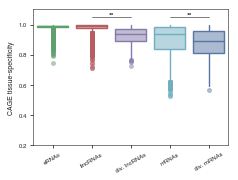

In [23]:
fig = plt.figure(figsize=(3.5, 2.5))
ax = sns.boxplot(data=all_tss, x="PromType2", y="tissue_sp_all", 
                 flierprops = dict(marker='o', markersize=5), order=TSS_CLASS_ORDER, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
mimic_r_boxplot(ax)


# calc p-vals b/w divergent and non
lincs = np.asarray(all_tss[all_tss["PromType2"] == "intergenic"]["tissue_sp_all"])
div_lncs = np.asarray(all_tss[all_tss["PromType2"] == "div_lnc"]["tissue_sp_all"])
pcs = np.asarray(all_tss[all_tss["PromType2"] == "protein_coding"]["tissue_sp_all"])
div_pcs = np.asarray(all_tss[all_tss["PromType2"] == "div_pc"]["tissue_sp_all"])

lincs = lincs[~np.isnan(lincs)]
div_lncs = div_lncs[~np.isnan(div_lncs)]
pcs = pcs[~np.isnan(pcs)]
div_pcs = div_pcs[~np.isnan(div_pcs)]

lnc_u, lnc_pval = stats.mannwhitneyu(lincs, div_lncs, alternative="two-sided", use_continuity=False)
pc_u, pc_pval = stats.mannwhitneyu(pcs, div_pcs, alternative="two-sided", use_continuity=False)
    
annotate_pval(ax, 1, 2, 1.05, 0, 1.035, lnc_pval, fontsize)
annotate_pval(ax, 3, 4, 1.05, 0, 1.035, pc_pval, fontsize)

plt.ylim((0.2, 1.1))
plt.xlabel("")
plt.ylabel("CAGE tissue-specificity")
fig.savefig("cage_ts_all_proms.pdf", dpi="figure", bbox_inches="tight")

In [27]:
print("lnc pval: %s" % lnc_pval)
print("pc pval: %s" % pc_pval)

lnc pval: 3.52167111424e-129
pc pval: 1.60610483516e-39


## define promoters as "ubiquitous" v "tissue-specific"
ubiquitous = on in >50% of samples
dynamic = on in < 50% of samples, in at least 1 sample on at > 10
tissue-sp = on in < 50% of samples

In [28]:
all_cage_exp["n_expr"] = all_cage_exp[samples].astype(bool).sum(axis=1)
all_cage_exp.head()

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_545,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id,av_exp,n_expr
0,0.54300,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.993829,0.666667,"chr10:100013403..100013414,-",0.023403,38
1,27.14998,0.89047,0.0,0.0,0.0,0.1056,0.0,0.101989,0.000000,0.0,...,0.0,1.603423,2.000139,0.629078,0.0,0.968756,0.666667,"chr10:100027943..100027958,-",5.375834,346
2,0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.210998,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.984646,NaN,"chr10:100076685..100076699,+",0.012479,34
3,0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.991970,NaN,"chr10:100150910..100150935,-",0.155925,80
4,0.00000,0.00000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.981522,NaN,"chr10:100150951..100150962,-",0.038083,49


In [29]:
len(all_cage_exp)

266886

In [30]:
def expr_type(row, samples, thresh):
    if row.n_expr > len(samples)/2:
        return "ubiquitous"
    else:
        exprs = list(row[samples])
        over_thresh = any(i >= thresh for i in exprs)
        if over_thresh > 0:
            return "dynamic"
        else:
            return "tissue-specific"

all_cage_exp["tss_type"] = all_cage_exp.apply(expr_type, axis=1, samples=samples, thresh=50)
all_cage_exp.sample(10)

,Group_0,Group_1,Group_2,Group_3,Group_4,Group_5,Group_6,Group_7,Group_8,Group_9,...,Group_546,Group_547,Group_548,Group_549,tissue_sp_all,tissue_sp_3,cage_id,av_exp,n_expr,tss_type
67852,0.000000,0.111309,0.000000,0.000000,0.000000,0.000000,3.742811,0.203978,0.000000,0.000000,...,0.000000,0.000000,1.348025,0.000000,0.975963,NaN,"chr18:55862847..55862864,+",0.302604,177,tissue-specific
45686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098692,0.000000,0.000000,...,0.000000,0.383380,0.000000,0.000000,0.986261,NaN,chr4:114390310-114390498,0.069522,97,tissue-specific
130171,2.714998,2.003557,0.000000,1.199924,12.700415,0.633602,1.497124,2.345743,0.632994,0.245773,...,1.603423,0.800056,1.977104,0.683652,0.971910,0.438404,"chr3:150264153..150264168,-",3.837055,531,ubiquitous
155810,0.000000,0.445235,8.154716,0.799950,0.000000,0.633602,1.871405,3.671598,1.898983,2.457729,...,2.405134,2.400167,1.168289,0.000000,0.853640,0.452501,"chr5:78809950..78809967,-",1.744536,495,ubiquitous
119483,0.000000,0.111309,0.000000,0.000000,0.000000,0.105600,0.000000,0.000000,0.000000,0.000000,...,0.801711,0.800056,0.089868,0.000000,0.954201,0.666667,"chr2:227660244..227660258,-",0.092207,190,tissue-specific
42686,0.000000,0.000000,0.000000,0.000000,0.199924,0.000000,0.000000,0.000000,0.000000,0.236226,...,0.000000,0.000000,0.000000,0.000000,0.983557,NaN,chr3:146224364-146224853,0.041603,104,tissue-specific
172183,0.000000,0.222617,0.000000,0.799950,0.211674,0.000000,0.000000,0.305966,0.000000,0.245773,...,2.405134,0.000000,0.089868,0.227884,0.954907,0.557555,"chr7:149565538..149565542,-",0.283717,354,ubiquitous
83931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.992985,NaN,"chr1:158323949..158323968,+",0.031718,8,tissue-specific
151133,0.000000,0.000000,0.000000,0.999937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.993820,NaN,"chr5:156772592..156772629,-",0.247165,55,tissue-specific
83097,0.000000,0.000000,4.659838,0.000000,1.058368,0.105600,0.748562,0.305966,4.219961,0.245773,...,0.000000,0.000000,0.718947,2.392783,0.921193,0.467172,"chr1:155100387..155100398,+",1.152981,362,ubiquitous


In [31]:
all_cage_exp.tss_type.value_counts()

tissue-specific    194476
ubiquitous          59108
dynamic             13302
Name: tss_type, dtype: int64

## write file

In [32]:
final = all_cage_exp[["cage_id", "av_exp", "tissue_sp_all",  "tissue_sp_3", "n_expr", "tss_type"]]
final.sample(5)

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
37635,"chr14:33403648..33403710,+",1.129132,0.948023,NaN,158,tissue-specific
97192,"chr1:86622655..86622673,-",0.389633,0.958411,0.666667,235,tissue-specific
196612,"chrX:123346476..123346486,-",0.009350,0.995570,NaN,4,tissue-specific
18898,chr14:94121988-94122062,0.040680,0.994640,NaN,38,tissue-specific
108435,"chr22:37956479..37956511,+",64.693745,0.900292,0.319863,496,ubiquitous


In [34]:
final[final["tss_type"] == "dynamic"].sample(5)

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
186538,"chr8:85464621..85464625,+",0.602673,0.994915,NaN,132,dynamic
41848,"chr14:96419967..96419968,+",0.388061,0.997658,NaN,22,dynamic
63601,chr9:132539303-132540203,0.395338,0.995998,0.666667,235,dynamic
30902,"chr13:100633445..100633468,+",1.870879,0.980760,0.569040,235,dynamic
7222,"chr10:81008258..81008313,-",1.283288,0.994111,NaN,138,dynamic


In [35]:
# chr16:2918256-2918257
final[final["cage_id"].str.contains("chr16:2918")]

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
50441,"chr16:2918192..2918219,-",0.374625,0.879067,0.477934,408,ubiquitous
22322,chr16:29189422-29189633,0.016184,0.989682,NaN,29,tissue-specific


In [36]:
final.to_csv("../../misc/other_files/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt", sep="\t", index=False)

In [37]:
len(final)

266886